In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or 

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8403067413145175562
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 2071178203367062346
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 4527805246345802783
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10927236711
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
    link {
      device_id: 2
      type: "StreamExecutor"
      strength: 1
    }
    link {
      device_id: 3
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 7619130682581338448
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:GPU:1"
device_type: "GPU"
mem

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3"

In [3]:
cd /media/datastorage/Phong/cifar100_png/

/media/datastorage/Phong/cifar100_png


In [4]:
ls -l

total 3420144
drwxrwxr-x   2 bribeiro bribeiro       4096 ago 10 00:45 checkpoints/
-rw-rw-r--   1 bribeiro bribeiro     283919 ago  9 23:36 Cifar10_SeResNet101_MulModels299_STD_1511_v8.csv
drwxrwxr-x   2 bribeiro bribeiro       4096 ago  9 23:38 pred_npy/
drwxrwxr-x 102 bribeiro bribeiro       4096 ago  8 20:55 test/
drwxrwxr-x 102 bribeiro bribeiro       4096 ago  8 21:08 test_resized/
drwxrwxr-x 102 bribeiro bribeiro       4096 ago  8 23:03 test_resized_299/
-rw-rw-r--   1 bribeiro bribeiro  585393095 ago 10 02:22 test_resized_299.zip
drwxrwxr-x 102 bribeiro bribeiro       4096 ago  8 20:55 train/
drwxrwxr-x 102 bribeiro bribeiro       4096 ago  8 21:06 train_resized/
drwxrwxr-x 102 bribeiro bribeiro       4096 ago  8 22:59 train_resized_299/
-rw-rw-r--   1 bribeiro bribeiro 2916502920 ago 10 02:24 train_resized_299.zip


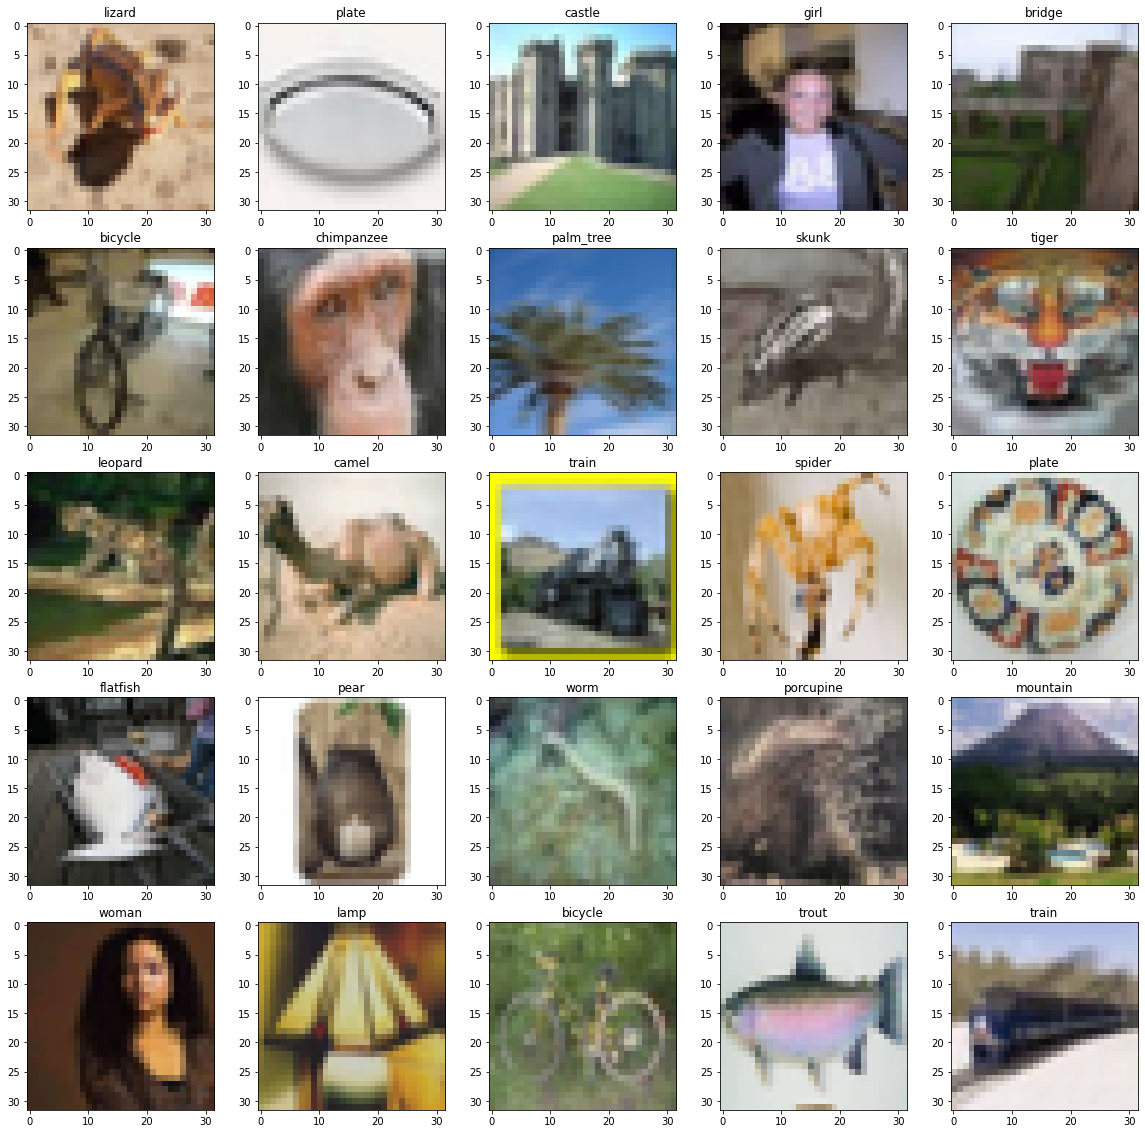

In [5]:
#Images/n02105855-Shetland_sheepdog/n02105855_9415.jpg

import glob
import os

import numpy as np
from matplotlib.image import imread
%matplotlib inline
import matplotlib.pyplot as plt

# get image parts
def get_image_parts(image_path):
    """Given a full path to an image, return its parts."""
    parts = image_path.split(os.path.sep)
    #print(parts)
    filename = parts[2]
    filename_no_ext = filename.split('.')[0]
    classname = parts[1]
    train_or_test = parts[0]
    
    return train_or_test, classname, filename_no_ext, filename
    
    
sample_images = list(glob.glob(os.path.join('train/', '*/*'), recursive=True))
np.random.seed(42)
rand_imgs = np.random.choice(sample_images, size=5*5)
fig, axarr = plt.subplots(5, 5, figsize=(20, 20))

for i, rand_img in enumerate(rand_imgs):
    train_or_test, classname, filename_no_ext, filename = get_image_parts(rand_img)
    
    j = i // 5
    k = i % 5
    axarr[j][k].imshow(imread(rand_img))
    axarr[j][k].title.set_text(classname)
    axarr[j][k].grid(False)

In [4]:
## fix for multi_gpu_model prediction time longer
from keras.layers import Lambda, concatenate
from keras import Model
import tensorflow as tf

def multi_gpu_model(model, gpus):
    if isinstance(gpus, (list, tuple)):
        num_gpus = len(gpus)
        target_gpu_ids = gpus
    else:
        num_gpus = gpus
        target_gpu_ids = range(num_gpus)

    def get_slice(data, i, parts):
        shape = tf.shape(data)
        batch_size = shape[:1]
        input_shape = shape[1:]
        step = batch_size // parts
        if i == num_gpus - 1:
            size = batch_size - step * i
        else:
            size = step
        size = tf.concat([size, input_shape], axis=0)
        stride = tf.concat([step, input_shape * 0], axis=0)
        start = stride * i
        return tf.slice(data, start, size)

    all_outputs = []
    for i in range(len(model.outputs)):
        all_outputs.append([])

    # Place a copy of the model on each GPU,
    # each getting a slice of the inputs.
    for i, gpu_id in enumerate(target_gpu_ids):
        with tf.device('/gpu:%d' % gpu_id):
            with tf.name_scope('replica_%d' % gpu_id):
                inputs = []
                # Retrieve a slice of the input.
                for x in model.inputs:
                    input_shape = tuple(x.get_shape().as_list())[1:]
                    slice_i = Lambda(get_slice,
                                   output_shape=input_shape,
                                   arguments={'i': i,
                                              'parts': num_gpus})(x)
                    inputs.append(slice_i)

                # Apply model on slice
                # (creating a model replica on the target device).
                outputs = model(inputs)
                if not isinstance(outputs, list):
                    outputs = [outputs]

                # Save the outputs for merging back together later.
                for o in range(len(outputs)):
                    all_outputs[o].append(outputs[o])

    # Merge outputs on CPU.
    with tf.device('/cpu:0'):
        merged = []
        for name, outputs in zip(model.output_names, all_outputs):
            merged.append(concatenate(outputs,
                                    axis=0, name=name))
        return Model(model.inputs, merged)


Using TensorFlow backend.


In [5]:
from keras.callbacks import Callback
import pickle
import sys

#Stop training on val_acc
class EarlyStoppingByAccVal(Callback):
    def __init__(self, monitor='val_acc', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current >= self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping" % epoch)
            self.model.stop_training = True

#Save large model using pickle formate instead of h5            
class SaveCheckPoint(Callback):
    def __init__(self, model, dest_folder):
        super(Callback, self).__init__()
        self.model = model
        self.dest_folder = dest_folder
        
        #initiate
        self.best_val_acc = 0
        self.best_val_loss = sys.maxsize #get max value
          
    def on_epoch_end(self, epoch, logs={}):
        val_acc = logs['val_acc']
        val_loss = logs['val_loss']

        if val_acc > self.best_val_acc:
            self.best_val_acc = val_acc
            
            # Save weights in pickle format instead of h5
            print('\nSaving val_acc %f at %s' %(self.best_val_acc, self.dest_folder))
            weigh= self.model.get_weights()

            #now, use pickle to save your model weights, instead of .h5
            #for heavy model architectures, .h5 file is unsupported.
            fpkl= open(self.dest_folder, 'wb') #Python 3
            pickle.dump(weigh, fpkl, protocol= pickle.HIGHEST_PROTOCOL)
            fpkl.close()
            
#             model.save('tmp.h5')
        elif val_acc == self.best_val_acc:
            if val_loss < self.best_val_loss:
                self.best_val_loss=val_loss
                
                # Save weights in pickle format instead of h5
                print('\nSaving val_acc %f at %s' %(self.best_val_acc, self.dest_folder))
                weigh= self.model.get_weights()

                #now, use pickle to save your model weights, instead of .h5
                #for heavy model architectures, .h5 file is unsupported.
                fpkl= open(self.dest_folder, 'wb') #Python 3
                pickle.dump(weigh, fpkl, protocol= pickle.HIGHEST_PROTOCOL)
                fpkl.close()                    

    100% |████████████████████████████████| 1.5MB 5.0MB/s ta 0:00:01
  Found existing installation: pip 18.0
    Uninstalling pip-18.0:
      Successfully uninstalled pip-18.0
  Rolling back uninstall of pip
Could not install packages due to an EnvironmentError: [Errno 13] Permission denied: '/usr/local/lib/python2.7/dist-packages/pip/__init__.py'
Consider using the `--user` option or check the permissions.

You are using pip version 18.0, however version 20.2.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [17]:
# !pip3 install -U git+https://github.com/qubvel/efficientnet

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-vb3m3z8q
  Created wheel for efficientnet: filename=efficientnet-1.1.0-py3-none-any.whl size=18397 sha256=95f04d200b64dc35fbfc7cfd61ad2e4ad58ae4fdfa173947ede1a90570234b4b
  Stored in directory: /tmp/pip-ephem-wheel-cache-g3cn4dad/wheels/35/74/df/c40832e841d98d6ecb62d74280c75efcfd07003f0dc73035ac
Successfully built efficientnet
  Attempting uninstall: efficientnet
    Found existing installation: efficientnet 1.1.0
    Uninstalling efficientnet-1.1.0:
      Successfully uninstalled efficientnet-1.1.0


In [8]:
#MUL 1 - Inception - ST

# from keras.applications import InceptionV3
# from keras.applications import Xception
# from keras.applications.inception_resnet_v2 import InceptionResNetV2

from keras.models import Model
from keras.layers import concatenate
from keras.layers import Dense, GlobalAveragePooling2D, Input, Embedding, LSTM, Flatten, GRU, Reshape
# from keras.applications.inception_v3 import preprocess_input

from efficientnet.keras import preprocess_input


from keras.layers import GaussianNoise

import efficientnet.keras as efn
f1_base = efn.EfficientNetB6(include_top=False, weights='imagenet', 
                input_shape=(299, 299, 3), 
                pooling='avg')

# f1_base = Xception(weights='imagenet', include_top=False, input_shape=(450,450,3))
# f1_base = EfficientNetB4((224,224,3), classes=1000, include_top=False, weights='imagenet')
f1_x = f1_base.output
# f1_x = GlobalAveragePooling2D()(f1_x)
# f1_x = Flatten()(f1_x)

# f1_x = Reshape([1,1792])(f1_x)  
# f1_x = GRU(2048, 
#             return_sequences=False,                       
# #             dropout=0.8                                     
#             input_shape=[1,1792])(f1_x)

#Regularization with noise
f1_x = GaussianNoise(0.1)(f1_x)

f1_x = Dense(1024, activation='relu')(f1_x)
f1_x = Dense(100, activation='softmax')(f1_x)
model_1 = Model(inputs=[f1_base.input],outputs=[f1_x])

model_1.summary()

Instructions for updating:
Shapes are always computed; don't use the compute_shapes as it has no effect.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 150, 150, 56) 1512        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 150, 150, 56) 224         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 150, 150, 56) 0           stem_bn[0][0]                    
____

In [0]:
cd ..

/content


In [0]:
ls -l

total 166512
drwxr-xr-x 2 2156 1103      4096 Jun  4  2009 cifar-10-batches-py/
-rw-r--r-- 1 root root 170498071 Jun  4  2009 cifar-10-python.tar.gz
drwxr-xr-x 1 root root      4096 Aug 27 16:17 sample_data/


In [ ]:
ls -l

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%cp gdrive/My\ Drive/cifar_train.zip cifar_train.zip 
%cp gdrive/My\ Drive/cifar_test.zip cifar_test.zip 

In [3]:
!unzip cifar_train.zip
!unzip cifar_test.zip

Archive:  cifar_train.zip
   creating: train/
   creating: train/5/
 extracting: train/5/english_toy_spaniel_s_000856.png  
 extracting: train/5/feist_s_000359.png  
 extracting: train/5/chihuahua_s_000967.png  
 extracting: train/5/domestic_dog_s_000300.png  
 extracting: train/5/maltese_dog_s_000418.png  
 extracting: train/5/pekingese_s_001812.png  
 extracting: train/5/maltese_dog_s_001102.png  
 extracting: train/5/puppy_s_001168.png  
 extracting: train/5/king_charles_spaniel_s_000298.png  
 extracting: train/5/puppy_s_002335.png  
 extracting: train/5/domestic_dog_s_000229.png  
 extracting: train/5/maltese_s_001798.png  
 extracting: train/5/mutt_s_000894.png  
 extracting: train/5/maltese_s_001988.png  
 extracting: train/5/puppy_s_000261.png  
 extracting: train/5/blenheim_spaniel_s_001169.png  
 extracting: train/5/maltese_s_001867.png  
 extracting: train/5/puppy_s_000667.png  
 extracting: train/5/maltese_dog_s_000830.png  
 extracting: train/5/peke_s_000005.png  
 extract

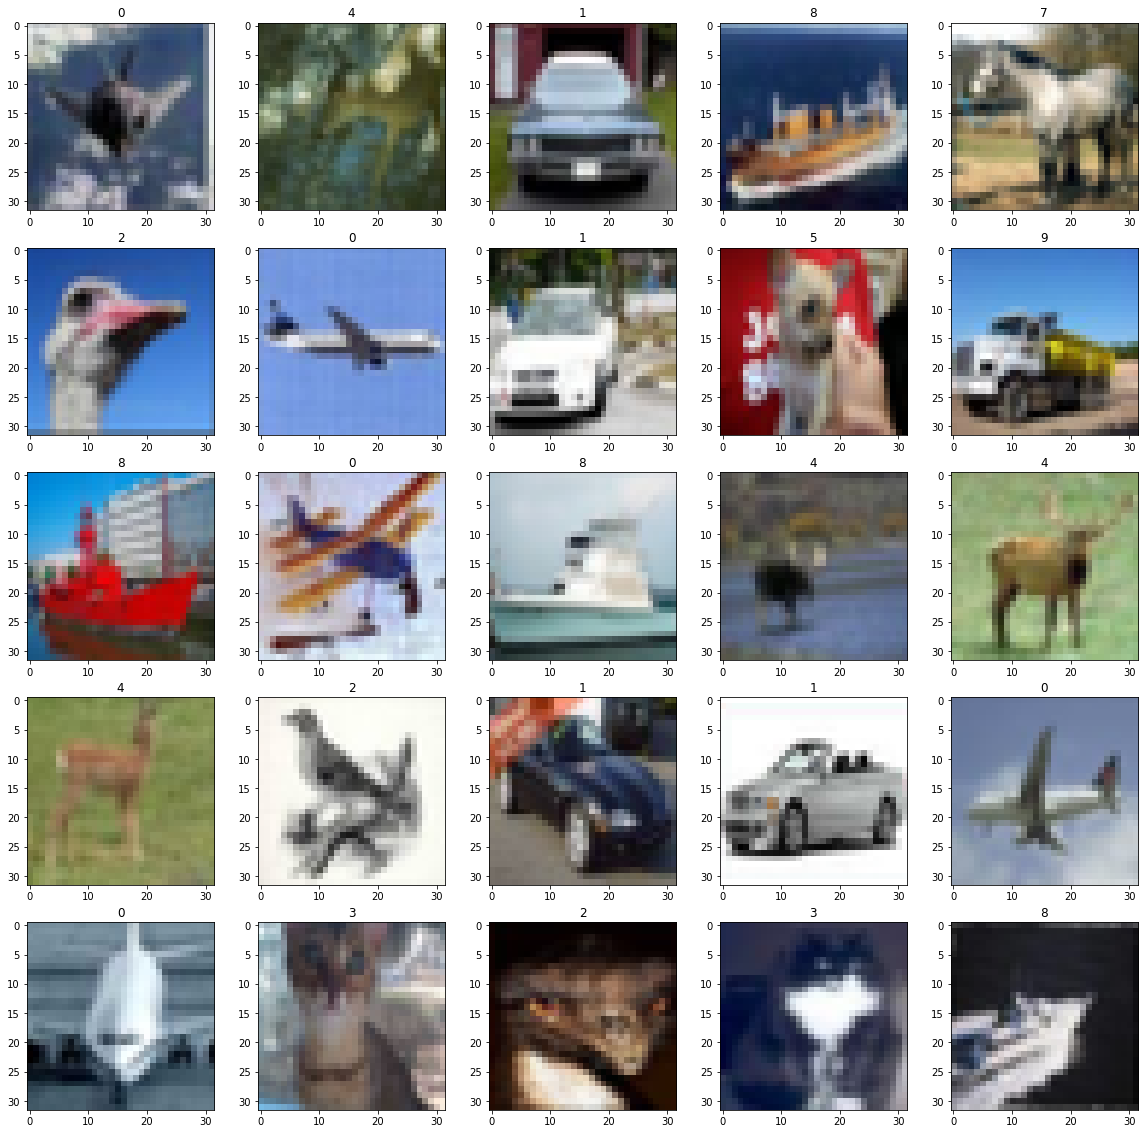

In [0]:
# #Images/n02105855-Shetland_sheepdog/n02105855_9415.jpg

# import glob
# import os

# import numpy as np
# from matplotlib.image import imread
# %matplotlib inline
# import matplotlib.pyplot as plt

# # get image parts
# def get_image_parts(image_path):
#     """Given a full path to an image, return its parts."""
#     parts = image_path.split(os.path.sep)
#     #print(parts)
#     filename = parts[2]
#     filename_no_ext = filename.split('.')[0]
#     classname = parts[1]
#     train_or_test = parts[0]
    
#     return train_or_test, classname, filename_no_ext, filename
    
    
# sample_images = list(glob.glob(os.path.join('train/', '*/*'), recursive=True))
# np.random.seed(42)
# rand_imgs = np.random.choice(sample_images, size=5*5)
# fig, axarr = plt.subplots(5, 5, figsize=(20, 20))

# for i, rand_img in enumerate(rand_imgs):
#     train_or_test, classname, filename_no_ext, filename = get_image_parts(rand_img)
    
#     j = i // 5
#     k = i % 5
#     axarr[j][k].imshow(imread(rand_img))
#     axarr[j][k].title.set_text(classname)
#     axarr[j][k].grid(False)

In [0]:
ls -l

In [0]:
# from PIL import Image
# import numpy

# def img_square(im_pth='', desired_size=224):
#     im = Image.open(im_pth)
#     old_size = im.size  # (width, height) format

#     ratio = float(desired_size)/max(old_size)
#     new_size = tuple([int(x*ratio) for x in old_size])

#     new_im = im.resize(new_size, Image.ANTIALIAS)

#     return new_im
    
# path = 'train/0/twinjet_s_001442.png'

# orig_arr = img_square(path, 399)   

# #convert to RGB and Save
# orig_arr = orig_arr.convert('RGB')
# orig_arr.save('test.jpg')

# from IPython.display import Image 
# Image(filename='test.jpg')

In [7]:
from PIL import Image
import numpy

def convert_img_square(im_pth='', dest_path='', desired_size=224):
#     print(im_pth)
    
    im = Image.open(im_pth)
    old_size = im.size  # (width, height) format

    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])

#     new_im = im.resize(new_size, Image.ANTIALIAS)
    new_im = im.resize(new_size)
    
    new_im = new_im.convert('RGB')
    
    new_im.save(dest_path)

    return True
    
# path = 'train/0/twinjet_s_001442.png'
# dest_path = 't1/test4.jpg'

# orig_arr = convert_img_square(path, dest_path, 499)   

# #convert to RGB and Save
# # orig_arr = orig_arr.convert('RGB')
# # orig_arr.save('t1/test2.jpg')

# from IPython.display import Image 
# Image(filename='t1/test4.jpg')

In [6]:
ls -l

total 3428560
drwxrwxr-x   2 bribeiro bribeiro       4096 ago 25 20:51 checkpoints/
-rw-rw-r--   1 bribeiro bribeiro     283798 ago 11 17:59 Cifar100_Eff_B0_299_1108_v1.csv
-rw-rw-r--   1 bribeiro bribeiro     283768 ago 24 03:48 Cifar100_Eff_B4_299_STD_L3_2408_v1.csv
-rw-rw-r--   1 bribeiro bribeiro     283798 ago 22 08:26 Cifar100_Eff_B7_299_2208_v1.csv
-rw-rw-r--   1 bribeiro bribeiro     283684 ago 21 20:12 Cifar100_EfficientB0_299_STD_2108.csv
-rw-rw-r--   1 bribeiro bribeiro     283703 ago 22 08:06 Cifar100_EfficientB0_299_STD_2208.csv
-rw-rw-r--   1 bribeiro bribeiro     283805 ago 25 22:50 Cifar100_InpResNet_MulModels299_2408_01.csv
-rw-rw-r--   1 bribeiro bribeiro     283827 ago 22 09:00 Cifar100_MulModels299_AVG_Assembe_2208.csv
-rw-rw-r--   1 bribeiro bribeiro     283795 ago 23 07:01 Cifar100_MulModels299_AVG_Assembe_2308_v1.csv
-rw-rw-r--   1 bribeiro bribeiro     283911 ago 24 05:19 Cifar100_MulModels299_AVG_Assembe_2408_a1.csv
-rw-rw-r--   1 bribeiro bribeiro     283735 a

In [0]:
%rm -r train_resized
%mkdir train_resized

In [5]:
# ####=======================
# import glob
# import os
# import shutil
# import random

# #move class folder from classname_# to classname/#

# def get_image_parts(image_path):
#     """Given a full path to an image, return its parts."""
#     parts = image_path.split(os.path.sep)
#     #print(parts)
#     filename = parts[2]
#     filename_no_ext = filename.split('.')[0]
#     classname = parts[1]
#     train_or_test = parts[0]
    
#     return train_or_test, classname, filename_no_ext, filename

# move_folders = ['train']
# dest_folder = 'train_resized_345'
# data_file = []

# # look for all images in sub-folders
# for folder in move_folders:
#     class_folders = glob.glob(os.path.join(folder, '*'))
#     print('folder %s' %class_folders)
    
# #     for sub_folder in class_folders:
# #         sub_class_folders = glob.glob(os.path.join(sub_folder, '*'))    
# #         print('sub folder %s' %sub_class_folders)
        
#     for iid_class in class_folders:
#         print(iid_class)
        
#         class_files = glob.glob(os.path.join(iid_class, '*.png'))
        
# #         #Determize Set# (No Suffle)
#         set = len(class_files)
#         inner = range(0*set, 1*set) #all

#         print('moving %d files' %(len(inner)))

# #         random_list = random.sample(range(len(class_files)), int(len(class_files)/5)) #1/5 dataset
# #         for idx in range(len(random_list)):

#         for idx in range(len(inner)):
#             src = class_files[inner[idx]]

#             train_or_test, classname, filename_no_ext, filename = get_image_parts(src)
#             dst = os.path.join(dest_folder, classname, filename)

#             # image directory
#             img_directory = os.path.join(dest_folder, classname)

#             # create folder if not existed
#             if not os.path.exists(img_directory):
#                 os.makedirs(img_directory)
                
#             # convert image
#             convert_img_square(src, dst, 345)
# #             #moving file
# #             shutil.move(src, dst)
# # #                 shutil.copy(src, dst)


folder ['train/5', 'train/4', 'train/9', 'train/1', 'train/0', 'train/2', 'train/6', 'train/7', 'train/8', 'train/3']
train/5
moving 5000 files
train/4
moving 5000 files
train/9
moving 5000 files
train/1
moving 5000 files
train/0
moving 5000 files
train/2
moving 5000 files
train/6
moving 5000 files
train/7
moving 5000 files
train/8
moving 5000 files
train/3
moving 5000 files


In [6]:
# ####=======================
# import glob
# import os
# import shutil
# import random

# #move class folder from classname_# to classname/#

# def get_image_parts(image_path):
#     """Given a full path to an image, return its parts."""
#     parts = image_path.split(os.path.sep)
#     #print(parts)
#     filename = parts[2]
#     filename_no_ext = filename.split('.')[0]
#     classname = parts[1]
#     train_or_test = parts[0]
    
#     return train_or_test, classname, filename_no_ext, filename

# move_folders = ['test']
# dest_folder = 'test_resized_345'
# data_file = []

# # look for all images in sub-folders
# for folder in move_folders:
#     class_folders = glob.glob(os.path.join(folder, '*'))
#     print('folder %s' %class_folders)
    
# #     for sub_folder in class_folders:
# #         sub_class_folders = glob.glob(os.path.join(sub_folder, '*'))    
# #         print('sub folder %s' %sub_class_folders)
        
#     for iid_class in class_folders:
#         print(iid_class)
        
#         class_files = glob.glob(os.path.join(iid_class, '*.png'))
        
# #         #Determize Set# (No Suffle)
#         set = len(class_files)
#         inner = range(0*set, 1*set) #all

#         print('moving %d files' %(len(inner)))

# #         random_list = random.sample(range(len(class_files)), int(len(class_files)/5)) #1/5 dataset
# #         for idx in range(len(random_list)):

#         for idx in range(len(inner)):
#             src = class_files[inner[idx]]

#             train_or_test, classname, filename_no_ext, filename = get_image_parts(src)
#             dst = os.path.join(dest_folder, classname, filename)

#             # image directory
#             img_directory = os.path.join(dest_folder, classname)

#             # create folder if not existed
#             if not os.path.exists(img_directory):
#                 os.makedirs(img_directory)
                
#             # convert image
#             convert_img_square(src, dst, 345)
# #             #moving file
# #             shutil.move(src, dst)
# # #                 shutil.copy(src, dst)


folder ['test/5', 'test/4', 'test/9', 'test/1', 'test/0', 'test/2', 'test/6', 'test/7', 'test/8', 'test/3']
test/5
moving 1000 files
test/4
moving 1000 files
test/9
moving 1000 files
test/1
moving 1000 files
test/0
moving 1000 files
test/2
moving 1000 files
test/6
moving 1000 files
test/7
moving 1000 files
test/8
moving 1000 files
test/3
moving 1000 files


In [0]:
path = 'train_resized/0/twinjet_s_001442.png'
# dest_path = 't1/test4.jpg'

# orig_arr = convert_img_square(path, dest_path, 499)   

# #convert to RGB and Save
# # orig_arr = orig_arr.convert('RGB')
# # orig_arr.save('t1/test2.jpg')

from IPython.display import Image 
Image(filename=path)

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from time import sleep

%matplotlib inline

image = mpimg.imread(path)
plt.imshow(image)
plt.show()

In [0]:
ls -l

In [0]:
!zip -r train_resized_299.zip train_resized
!zip -r test_resized_299.zip test_resized

In [0]:
%cp train_resized_299.zip gdrive/My\ Drive/cifar_train_resized_299.zip
%cp test_resized_299.zip gdrive/My\ Drive/cifar_test_resized_299.zip 

In [0]:
cd gdrive/My\ Drive

In [0]:
ls -l

In [7]:
# !pip install keras_efficientnets

In [7]:
# #MUL 1 - Inception - ST

# # from keras.applications import InceptionV3
# # from keras.applications import Xception
# # from keras.applications.inception_resnet_v2 import InceptionResNetV2

# from keras.models import Model
# from keras.layers import concatenate
# from keras.layers import Dense, GlobalAveragePooling2D, Input, Embedding, LSTM
# from keras.applications.inception_v3 import preprocess_input

# from keras.layers import GaussianNoise

# from keras_efficientnets import EfficientNetB5

# # f1_base = Xception(weights='imagenet', include_top=False, input_shape=(450,450,3))
# f1_base = EfficientNetB5((345,345,3), classes=1000, include_top=False, weights='imagenet')
# f1_x = f1_base.output
# f1_x = GlobalAveragePooling2D()(f1_x)

# #Regularization with noise
# f1_x = GaussianNoise(0.1)(f1_x)

# f1_x = Dense(1024, activation='relu')(f1_x)
# f1_x = Dense(10, activation='softmax')(f1_x)
# model_1 = Model(inputs=[f1_base.input],outputs=[f1_x])

# print(model_1.summary())

Using TensorFlow backend.


Instructions for updating:
Shapes are always computed; don't use the compute_shapes as it has no effect.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 345, 345, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 173, 173, 48) 1296        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 173, 173, 48) 192         conv2d_1[0][0]                   
__________________________________________________________________________________________________
swish_1 (Swish)                 (None, 173, 173, 48) 0           batch_normalization_1[0][0]      
____

In [0]:
ls -l

total 413780
-rw-------  1 root root  24485111 Oct 16 22:25 cifar_test.zip
-rw-------  1 root root 122511088 Oct 16 22:25 cifar_train.zip
drwx------  3 root root      4096 Oct 17 00:10 gdrive/
drwxr-xr-x  1 root root      4096 Aug 27 16:17 sample_data/
drwxr-xr-x  2 root root      4096 Oct 16 23:28 t1/
drwxr-xr-x 12 root root      4096 Oct 16 15:36 test/
drwxr-xr-x 12 root root      4096 Oct 16 23:44 test_resized/
-rw-r--r--  1 root root  46093692 Oct 17 00:01 test_resized_299.zip
drwxr-xr-x 12 root root      4096 Oct 16 15:33 train/
drwxr-xr-x 12 root root      4096 Oct 16 23:41 train_resized/
-rw-r--r--  1 root root 230580828 Oct 17 00:01 train_resized_299.zip


In [0]:
mkdir checkpoints

In [9]:
#Non-Groups
#Split training and validation
#Using Expert Data

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from keras.optimizers import Adam
# from keras.utils import multi_gpu_model

import time, os
from math import ceil
import multiprocessing

train_datagen = ImageDataGenerator(
#     rescale = 1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,##
#     brightness_range=[0.5, 1.5],##
    channel_shift_range=10,##
    fill_mode='nearest',
    preprocessing_function=preprocess_input,
)

test_datagen = ImageDataGenerator(
#     rescale = 1./255
    preprocessing_function=preprocess_input
)

NUM_GPU = 4
batch_size = 36

train_set = train_datagen.flow_from_directory('train_resized_299',
                                                 target_size = (299, 299),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=True,
                                                 seed=7,
#                                                  subset="training"
                                              )

valid_set = test_datagen.flow_from_directory('test_resized_299',
                                                 target_size = (299, 299),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=False,
                                                 seed=7,
#                                                  subset="validation"
                                             )

model_txt = 'st'
# Helper: Save the model.
savedfilename = os.path.join('checkpoints','Cifar100_Eff_B6_299_STD_tmp.hdf5')

checkpointer = ModelCheckpoint(savedfilename,
                          monitor='val_acc', verbose=1, 
                          save_best_only=True, mode='max',save_weights_only=True)########

# Helper: TensorBoard
tb = TensorBoard(log_dir=os.path.join('cifar100_output', 'logs', model_txt))

# Helper: Save results.
timestamp = time.time()
csv_logger = CSVLogger(os.path.join('cifar100_output', 'logs', model_txt + '-' + 'training-' + \
    str(timestamp) + '.log'))

earlystopping = EarlyStoppingByAccVal(monitor='val_acc', value=0.9900, verbose=1)

#Using multiple models if more than 1 GPU
if NUM_GPU != 1:
    model_mul = multi_gpu_model(model_1, gpus=NUM_GPU)
else:
    model_mul = model_1
    
epochs = 40##!!!
lr = 1e-4
decay = lr/epochs
optimizer = Adam(lr=lr, decay=decay)

model_mul.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

step_size_train=ceil(train_set.n/train_set.batch_size)
step_size_valid=ceil(valid_set.n/valid_set.batch_size)
# step_size_test=ceil(testing_set.n//testing_set.batch_size)

result = model_mul.fit_generator(
    generator = train_set, 
    steps_per_epoch = step_size_train,
    validation_data = valid_set,
    validation_steps = step_size_valid,
    shuffle=True,
    epochs=epochs,
    callbacks=[earlystopping, checkpointer],
#     callbacks=[tb, csv_logger, checkpointer, earlystopping],        
    verbose=1) 

Found 50000 images belonging to 100 classes.
Found 10000 images belonging to 100 classes.
Epoch 1/40
1389/1389 [==============================] - 1402s 1s/step - loss: 2.4346 - acc: 0.3900 - val_loss: 0.9266 - val_acc: 0.7530

Epoch 00001: val_acc improved from -inf to 0.75300, saving model to checkpoints/Cifar100_Eff_B6_299_STD_tmp.hdf5
Epoch 2/40
1389/1389 [==============================] - 1257s 905ms/step - loss: 1.3861 - acc: 0.6111 - val_loss: 0.6372 - val_acc: 0.8068

Epoch 00002: val_acc improved from 0.75300 to 0.80680, saving model to checkpoints/Cifar100_Eff_B6_299_STD_tmp.hdf5
Epoch 3/40
1389/1389 [==============================] - 1258s 906ms/step - loss: 1.1503 - acc: 0.6723 - val_loss: 0.5840 - val_acc: 0.8277

Epoch 00003: val_acc improved from 0.80680 to 0.82770, saving model to checkpoints/Cifar100_Eff_B6_299_STD_tmp.hdf5
Epoch 4/40
1389/1389 [==============================] - 1258s 906ms/step - loss: 0.9998 - acc: 0.7108 - val_loss: 0.5542 - val_acc: 0.8338

Epoch 00

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1389/1389 [==============================] - 1296s 933ms/step - loss: 0.1971 - acc: 0.9375 - val_loss: 0.7276 - val_acc: 0.8575

Epoch 00036: val_acc did not improve from 0.86870
Epoch 37/40
1389/1389 [==============================] - 1297s 934ms/step - loss: 0.1860 - acc: 0.9406 - val_loss: 0.7551 - val_acc: 0.8536

Epoch 00037: val_acc did not improve from 0.86870
Epoch 38/40
 685/1389 [=============>................] - ETA: 10:14 - loss: 0.1845 - acc: 0.9437

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [11]:
model_mul.load_weights(os.path.join('checkpoints', 'Cifar100_Eff_B6_299_STD_tmp.hdf5'))

In [12]:
#Non-Groups
#Split training and validation
#Using Expert Data

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from keras.optimizers import Adam
# from keras.utils import multi_gpu_model

import time, os
from math import ceil
import multiprocessing

savedfilename = os.path.join('checkpoints', 'Cifar100_Eff_B6_299_STD_L2.hdf5')
checkpointer = ModelCheckpoint(savedfilename,
                          monitor='val_acc', verbose=1, 
                          save_best_only=True, mode='max',save_weights_only=True)########

epochs = 15##!!!
lr = 1e-5
decay = lr/epochs
optimizer = Adam(lr=lr, decay=decay)

model_mul.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

result = model_mul.fit_generator(
    generator = train_set, 
    steps_per_epoch = step_size_train,
    validation_data = valid_set,
    validation_steps = step_size_valid,
    shuffle=True,
    epochs=epochs,
    callbacks=[earlystopping, checkpointer],
#     callbacks=[tb, csv_logger, checkpointer, earlystopping],        
    verbose=1) 

Epoch 1/15
1389/1389 [==============================] - 1431s 1s/step - loss: 0.3003 - acc: 0.9056 - val_loss: 0.5322 - val_acc: 0.8728

Epoch 00001: val_acc improved from -inf to 0.87280, saving model to checkpoints/Cifar100_Eff_B6_299_STD_L2.hdf5
Epoch 2/15
1389/1389 [==============================] - 1288s 928ms/step - loss: 0.2745 - acc: 0.9143 - val_loss: 0.5272 - val_acc: 0.8751

Epoch 00002: val_acc improved from 0.87280 to 0.87510, saving model to checkpoints/Cifar100_Eff_B6_299_STD_L2.hdf5
Epoch 3/15
1389/1389 [==============================] - 1295s 932ms/step - loss: 0.2587 - acc: 0.9181 - val_loss: 0.5295 - val_acc: 0.8757

Epoch 00003: val_acc improved from 0.87510 to 0.87570, saving model to checkpoints/Cifar100_Eff_B6_299_STD_L2.hdf5
Epoch 4/15
1389/1389 [==============================] - 1290s 928ms/step - loss: 0.2520 - acc: 0.9199 - val_loss: 0.5276 - val_acc: 0.8771

Epoch 00004: val_acc improved from 0.87570 to 0.87710, saving model to checkpoints/Cifar100_Eff_B6_29

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1389/1389 [==============================] - 1302s 937ms/step - loss: 0.2101 - acc: 0.9337 - val_loss: 0.5273 - val_acc: 0.8783

Epoch 00011: val_acc did not improve from 0.88000
Epoch 12/15
1389/1389 [==============================] - 1315s 947ms/step - loss: 0.2034 - acc: 0.9356 - val_loss: 0.5332 - val_acc: 0.8788

Epoch 00012: val_acc did not improve from 0.88000
Epoch 13/15
1389/1389 [==============================] - 1314s 946ms/step - loss: 0.2000 - acc: 0.9369 - val_loss: 0.5373 - val_acc: 0.8788

Epoch 00013: val_acc did not improve from 0.88000
Epoch 14/15
1389/1389 [==============================] - 1315s 947ms/step - loss: 0.2000 - acc: 0.9360 - val_loss: 0.5335 - val_acc: 0.8775

Epoch 00014: val_acc did not improve from 0.88000
Epoch 15/15
1389/1389 [==============================] - 1314s 946ms/step - loss: 0.1941 - acc: 0.9387 - val_loss: 0.5346 - val_acc: 0.8788

Epoch 00015: val_acc did not improve from 0.88000


In [13]:
# #Using multiple models if more than 1 GPU
# NUM_GPU = 4
# if NUM_GPU != 1:
#     model_mul = multi_gpu_model(model_1, gpus=NUM_GPU)

model_mul.load_weights(os.path.join('checkpoints', 'Cifar100_Eff_B6_299_STD_L2.hdf5'))

In [14]:
#Non-Groups
#Split training and validation
#Using Expert Data

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from keras.optimizers import Adam
# from keras.utils import multi_gpu_model

import time, os
from math import ceil
import multiprocessing

savedfilename = os.path.join('checkpoints', 'Cifar100_Eff_B6_299_STD_L3.hdf5')
checkpointer = ModelCheckpoint(savedfilename,
                          monitor='val_acc', verbose=1, 
                          save_best_only=True, mode='max',save_weights_only=True)########

epochs = 15##!!!
lr = 1e-5
decay = lr/epochs
optimizer = Adam(lr=lr, decay=decay)

model_mul.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

result = model_mul.fit_generator(
    generator = train_set, 
    steps_per_epoch = step_size_train,
    validation_data = valid_set,
    validation_steps = step_size_valid,
    shuffle=True,
    epochs=epochs,
    callbacks=[earlystopping, checkpointer],
#     callbacks=[tb, csv_logger, checkpointer, earlystopping],        
    verbose=1) 

Epoch 1/15
1389/1389 [==============================] - 1390s 1s/step - loss: 0.2136 - acc: 0.9324 - val_loss: 0.5236 - val_acc: 0.8804

Epoch 00001: val_acc improved from -inf to 0.88040, saving model to checkpoints/Cifar100_Eff_B6_299_STD_L3.hdf5
Epoch 2/15
1389/1389 [==============================] - 1258s 905ms/step - loss: 0.2124 - acc: 0.9328 - val_loss: 0.5258 - val_acc: 0.8796

Epoch 00002: val_acc did not improve from 0.88040
Epoch 3/15
1389/1389 [==============================] - 1258s 905ms/step - loss: 0.2026 - acc: 0.9357 - val_loss: 0.5282 - val_acc: 0.8782

Epoch 00003: val_acc did not improve from 0.88040
Epoch 4/15
1389/1389 [==============================] - 1258s 906ms/step - loss: 0.1981 - acc: 0.9376 - val_loss: 0.5320 - val_acc: 0.8763

Epoch 00004: val_acc did not improve from 0.88040
Epoch 5/15
1389/1389 [==============================] - 1257s 905ms/step - loss: 0.1980 - acc: 0.9378 - val_loss: 0.5341 - val_acc: 0.8762

Epoch 00005: val_acc did not improve from

KeyboardInterrupt: 

In [15]:
model_mul.load_weights(os.path.join('checkpoints', 'Cifar100_Eff_B6_299_STD_L3.hdf5'))

In [16]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import time, os
from math import ceil

# PREDICT ON OFFICIAL TEST
train_datagen = ImageDataGenerator(
#     rescale = 1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,##
#     brightness_range=[0.5, 1.5],##
    channel_shift_range=10,##
    fill_mode='nearest',
    preprocessing_function=preprocess_input,
)

test_datagen1 = ImageDataGenerator(
#     rescale = 1./255,
    preprocessing_function=preprocess_input
)

batch_size = 36

train_set = train_datagen.flow_from_directory('train_resized_299',
                                                 target_size = (299, 299),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=True,
                                                 seed=7,
#                                                  subset="training"
                                              )

test_set1 = test_datagen1.flow_from_directory('test_resized_299',
                                                 target_size = (299, 299),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=False,
                                                 seed=7,
#                                                  subset="validation"
                                             )

if NUM_GPU != 1:
    predict1=model_mul.predict_generator(test_set1, steps = ceil(test_set1.n/test_set1.batch_size),verbose=1)
# else:
#     predict1=model.predict_generator(test_set1, steps = ceil(test_set1.n/test_set1.batch_size),verbose=1)
    
predicted_class_indices=np.argmax(predict1,axis=1)
labels = (train_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions1 = [labels[k] for k in predicted_class_indices]

import pandas as pd

filenames=test_set1.filenames
results=pd.DataFrame({"file_name":filenames,
                      "predicted1":predictions1,
                      })
results.to_csv('Cifar100_Eff_B6_299_3008_v1.csv')
results.head()

Found 50000 images belonging to 100 classes.
Found 10000 images belonging to 100 classes.
278/278 [==============================] - 118s 424ms/step


file_name predicted1
0  apple/0001.png      apple
1  apple/0002.png      apple
2  apple/0003.png      apple
3  apple/0004.png      apple
4  apple/0005.png      apple

In [19]:
cp Cifar10_Eff_B5_345_1511_v1.csv /home/bribeiro/Phong/Nat19/Cifar10_Eff_B5_345_1511_v1.csv

In [17]:
np.save(os.path.join('pred_npy','Cifar100_Eff_B6_299_L3.npy'), predict1)

In [29]:
from keras.preprocessing.image import ImageDataGenerator
from math import ceil
import numpy as np

batch_size = 72

#Crop-Official Test
def random_crop(img, random_crop_size):
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1]
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return img[y:(y+dy), x:(x+dx), :]

def crop_generator(batches, crop_length):
    """Generate random crops from the image batches"""
    while True:
        batch_x, batch_y = next(batches)
        batch_crops = np.zeros((batch_x.shape[0], crop_length, crop_length, 3))
        for i in range(batch_x.shape[0]):
            batch_crops[i] = random_crop(batch_x[i], (crop_length, crop_length))
        yield (batch_crops, batch_y)

test_datagen_crop = ImageDataGenerator(
#     rescale = 1./255,
    preprocessing_function=preprocess_input
)

testing_set_crop = test_datagen_crop.flow_from_directory('test_resized_345',
                                                 target_size = (370, 370),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=False,
                                                 seed=7,
#                                                  subset="training"
                                              )
#customized generator
test_crops = crop_generator(testing_set_crop, 345)

step_size_test_crop = ceil(testing_set_crop.n/testing_set_crop.batch_size)

tta_steps = 4
# predictions = []

# import tensorflow as tf
# with tf.device('/gpu:0'):
for i in range(tta_steps):
    print(i)
    testing_set_crop.reset()
    if NUM_GPU != 1:
        preds=model_mul.predict_generator(test_crops, 
                                           steps = step_size_test_crop,
#                                            max_queue_size=16,
#                                                use_multiprocessing=True,
#                                            workers=1,
                                           verbose=1)    
#     else:
#         preds=model.predict_generator(test_crops, 
#                                            steps = step_size_test_crop,
#                                            max_queue_size=16,
# #                                                use_multiprocessing=True,
#                                            workers=1,
#                                            verbose=1)  
#     preds=model_2.predict_generator(test_crops,steps = step_size_test_crop,verbose=1)  
    predictions.append(preds)

mean_pred = np.mean(predictions, axis=0)

predicted_class_indices_mean=np.argmax(mean_pred,axis=1)
labels = (train_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
finalpre = [labels[k] for k in predicted_class_indices_mean]

import pandas as pd
filenames=testing_set_crop.filenames
results=pd.DataFrame({"id":filenames,
                      "predicted":finalpre,
                      })
results.to_csv('Cifar10_Eff_B5_345_STD_tta_7.csv')
results.head(10)

Found 10000 images belonging to 10 classes.
0
139/139 [==============================] - 72s 521ms/step
1
139/139 [==============================] - 72s 515ms/step
2
139/139 [==============================] - 71s 513ms/step
3
139/139 [==============================] - 73s 527ms/step


id predicted
0  0/aeroplane_s_000002.png         0
1  0/aeroplane_s_000040.png         0
2  0/aeroplane_s_000045.png         0
3  0/aeroplane_s_000063.png         0
4     0/airbus_s_000009.png         0
5     0/airbus_s_000030.png         0
6     0/airbus_s_000049.png         0
7     0/airbus_s_000099.png         0
8     0/airbus_s_000108.png         0
9     0/airbus_s_000131.png         0

In [30]:
cp Cifar10_Eff_B5_345_STD_tta_7.csv /home/bribeiro/Phong/Nat19/Cifar10_Eff_B5_345_STD_tta_7.csv

In [28]:
np.save(os.path.join('pred_npy','Cifar10_Eff_B5_345_L2_TTA3.npy'), mean_pred)

In [15]:
#Non-Groups
#Split training and validation
#Using Expert Data

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from keras.optimizers import Adam
# from keras.utils import multi_gpu_model

import time, os
from math import ceil
import multiprocessing

savedfilename = os.path.join('checkpoints', 'Cifar100_Eff_B7_299_STD_L3.hdf5')
checkpointer = ModelCheckpoint(savedfilename,
                          monitor='val_acc', verbose=1, 
                          save_best_only=True, mode='max',save_weights_only=True)########

epochs = 15##!!!
lr = 1e-6
decay = lr/epochs
optimizer = Adam(lr=lr, decay=decay)

model_mul.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

result = model_mul.fit_generator(
    generator = train_set, 
    steps_per_epoch = step_size_train,
    validation_data = valid_set,
    validation_steps = step_size_valid,
    shuffle=True,
    epochs=epochs,
    callbacks=[earlystopping, checkpointer],
#     callbacks=[tb, csv_logger, checkpointer, earlystopping],        
    verbose=1) 

Epoch 1/15
2084/2084 [==============================] - 2252s 1s/step - loss: 0.2817 - acc: 0.9113 - val_loss: 0.6402 - val_acc: 0.8704

Epoch 00001: val_acc improved from -inf to 0.87040, saving model to checkpoints/Cifar100_Eff_B7_299_STD_L3.hdf5
Epoch 2/15
2084/2084 [==============================] - 2075s 996ms/step - loss: 0.2753 - acc: 0.9129 - val_loss: 0.6352 - val_acc: 0.8721

Epoch 00002: val_acc improved from 0.87040 to 0.87210, saving model to checkpoints/Cifar100_Eff_B7_299_STD_L3.hdf5
Epoch 3/15
2084/2084 [==============================] - 2077s 997ms/step - loss: 0.2729 - acc: 0.9129 - val_loss: 0.6345 - val_acc: 0.8708

Epoch 00003: val_acc did not improve from 0.87210
Epoch 4/15
2084/2084 [==============================] - 2075s 995ms/step - loss: 0.2679 - acc: 0.9128 - val_loss: 0.6283 - val_acc: 0.8716

Epoch 00004: val_acc did not improve from 0.87210
Epoch 5/15
2084/2084 [==============================] - 2076s 996ms/step - loss: 0.2749 - acc: 0.9134 - val_loss: 0.

In [8]:
# #Using multiple models if more than 1 GPU
# NUM_GPU = 4
# if NUM_GPU != 1:
#     model_mul = multi_gpu_model(model_1, gpus=NUM_GPU)

model_mul.load_weights(os.path.join('checkpoints', 'Cifar100_Eff_B7_299_STD_L3.hdf5'))

In [9]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import time, os
from math import ceil

# PREDICT ON OFFICIAL TEST
train_datagen = ImageDataGenerator(
#     rescale = 1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,##
#     brightness_range=[0.5, 1.5],##
    channel_shift_range=10,##
    fill_mode='nearest',
    preprocessing_function=preprocess_input,
)

test_datagen1 = ImageDataGenerator(
#     rescale = 1./255,
    preprocessing_function=preprocess_input
)

batch_size = 36

train_set = train_datagen.flow_from_directory('train_resized_299',
                                                 target_size = (299, 299),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=True,
                                                 seed=7,
#                                                  subset="training"
                                              )

test_set1 = test_datagen1.flow_from_directory('test_resized_299',
                                                 target_size = (299, 299),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=False,
                                                 seed=7,
#                                                  subset="validation"
                                             )

if NUM_GPU != 1:
    predict1=model_mul.predict_generator(test_set1, steps = ceil(test_set1.n/test_set1.batch_size),verbose=1)
# else:
#     predict1=model.predict_generator(test_set1, steps = ceil(test_set1.n/test_set1.batch_size),verbose=1)
    
predicted_class_indices=np.argmax(predict1,axis=1)
labels = (train_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions1 = [labels[k] for k in predicted_class_indices]

import pandas as pd

filenames=test_set1.filenames
results=pd.DataFrame({"file_name":filenames,
                      "predicted1":predictions1,
                      })
results.to_csv('Cifar100_Eff_B7_299_2208_v1.csv')
results.head()

Found 50000 images belonging to 100 classes.
Found 10000 images belonging to 100 classes.
278/278 [==============================] - 150s 541ms/step


file_name predicted1
0  apple/0001.png      apple
1  apple/0002.png      apple
2  apple/0003.png      apple
3  apple/0004.png       pear
4  apple/0005.png      apple

In [10]:
np.save(os.path.join('pred_npy','Cifar100_Eff_B7_299_STD_L3_v2.npy'), predict1)